In [8]:
import json
import sys
import h5py
import os
import numpy as np

import matplotlib.pyplot as plt
# import seaborn as sns
import ot

def load_config():
    with open('../config.json', 'r') as f:
        config = json.load(f)
    return config

def get_database_path():
    config = load_config()
    if sys.platform.startswith('linux'):
        return config['linux']['database_path']
    elif sys.platform.startswith('win32') or sys.platform.startswith('cygwin'):
        return config['windows']['database_path']
    else:
        raise Exception("Unsupported OS")

def get_h5_files():
    config = load_config()
    return config['bkg_files'], config['sig_files']

def read_h5_file(path, file_name):
    return h5py.File(os.path.join(path, file_name), 'r')


In [9]:
database_path = get_database_path()
print("Database Path:", database_path)

bkg_files, sig_files = get_h5_files()
print("bkg_files:", bkg_files)
print("sig_files:", sig_files)

Database Path: D:\ADwithAE
bkg_files: [{'type': 'SM', 'file': 'background_for_training.h5'}]
sig_files: [{'type': 'A -> 4 leptons', 'file': 'Ato4l_lepFilter_13TeV_filtered.h5'}, {'type': 'LQ -> b tau', 'file': 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5'}, {'type': 'h^0 -> tau tau', 'file': 'hToTauTau_13TeV_PU20_filtered.h5'}, {'type': 'h+ -> tau nu', 'file': 'hChToTauNu_13TeV_PU20_filtered.h5'}]


In [10]:
print("Background Files:")
for dataset in bkg_files:
    print(dataset['type'], dataset['file'])

print("Signal Files:")
for dataset in sig_files:
    print(dataset['type'], dataset['file'])

Background Files:
SM background_for_training.h5
Signal Files:
A -> 4 leptons Ato4l_lepFilter_13TeV_filtered.h5
LQ -> b tau leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
h^0 -> tau tau hToTauTau_13TeV_PU20_filtered.h5
h+ -> tau nu hChToTauNu_13TeV_PU20_filtered.h5


In [11]:
f = read_h5_file(database_path, bkg_files[0]['file'])
for key in f.keys():
    print(f[key].shape)

(13451915, 19, 4)
(4,)
(4,)


In [12]:
print(f['Particles_Classes'][:])
print(f['Particles_Names'][:])
particle_classes = ["None", "MET", "Electron", "Muon", "Jet"]

[b'MET_class_1' b'Four_Ele_class_2' b'Four_Mu_class_3' b'Ten_Jet_class_4']
[b'Pt' b'Eta' b'Phi' b'Class']


In [13]:
f_particles = f['Particles']

In [23]:
n = np.random.randint(f_particles.shape[0])
print("Event ", n)
print(f_particles[n])

Event  9419802
[[16.22810936  0.         -0.25965568  1.        ]
 [30.11009407  0.23982726 -0.19447096  2.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [83.65494537 -0.36726803  2.23601413  4.        ]
 [83.013237    0.1891537  -0.25809681  4.        ]
 [38.55702972 -3.41256833 -1.69512856  4.        ]
 [31.66387939  2.34364438  2.97591543  4.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


In [24]:
test_event = f_particles[0]
print(test_event)
def select_non_zero_constituents(event):
    # Select only constituents with non-zero pT
    return event[event[:, 0] != 0]
print("Non-zero constituents", select_non_zero_constituents(test_event))

[[27.41296387  0.         -2.0499022   1.        ]
 [24.20996857  1.63350999 -0.10349621  2.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Non-zero constituents [[27.412

In [25]:
def parse_event(event):
    # Returns MET, electron and muon constituents with non-zero pT
    non_zero_part = select_non_zero_constituents(event)

    met_part = non_zero_part[non_zero_part[:, 3] == 1]
    electron_part = non_zero_part[non_zero_part[:, 3] == 2]
    muon_part = non_zero_part[non_zero_part[:, 3] == 3]
    jet_part = non_zero_part[non_zero_part[:, 3] == 4]

    return met_part, electron_part, muon_part, jet_part
print(parse_event(test_event))

(array([[27.41296387,  0.        , -2.0499022 ,  1.        ]]), array([[24.20996857,  1.63350999, -0.10349621,  2.        ]]), array([], shape=(0, 4), dtype=float64), array([], shape=(0, 4), dtype=float64))


In [26]:
def plot_event_cloud(event):
    met_part, electron_part, muon_part, jet_part = parse_event(event)

    plt.figure(figsize=(5, 5))
    plt.xlim(-5, 5)
    plt.ylim(-3.5, 3.5)
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$\phi$')

    plt.scatter(met_part[:, 1], met_part[:, 2], color='red', marker='^', s=met_part[:,0], label='MET')

    if electron_part.size:
        plt.scatter(electron_part[:, 1], electron_part[:, 2], color='blue', marker='o', s=electron_part[:,0], label='Electrons')
    
    if muon_part.size:
        plt.scatter(muon_part[:, 1], muon_part[:, 2], color='green', marker='s', s=muon_part[:,0], label='Muons')

    if jet_part.size:
        plt.scatter(jet_part[:, 1], jet_part[:, 2], color='purple', marker='*', s=jet_part[:,0], label='Jets')
    
    plt.legend()
    plt.grid(True)
    plt.show()


Event 8168494
[[21.78929901  0.         -1.83613396  1.        ]
 [26.28133965  1.41901147 -0.41383144  2.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [40.88951874  1.41753399 -0.36384001  4.        ]
 [38.05955124  1.98444462  2.74265194  4.        ]
 [20.06712341  1.10462976  1.99170935  4.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


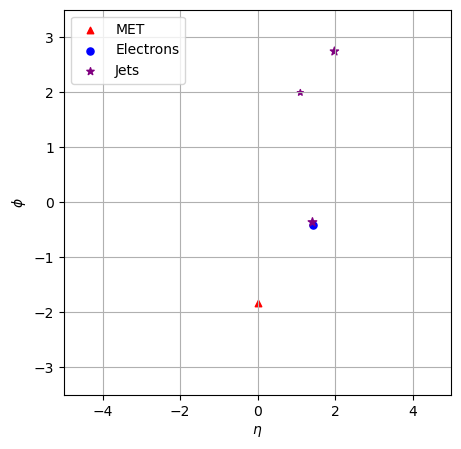

In [30]:
n = np.random.randint(f_particles.shape[0])
print("Event", n)
test_event = f_particles[n]
print(test_event)
plot_event_cloud(test_event)

In [12]:
pT_MET = f_particles[:, 0, 0]
eta_MET = f_particles[:,0,1]
phi_MET = f_particles[:,0,2]

print("Max of p_T_MET:", max(pT_MET))
print("Max of eta_MET:", max(eta_MET))
print("Max of phi_MET:", max(phi_MET))

print("Min of p_T_MET:", min(pT_MET))
print("Min of eta_MET:", min(eta_MET))
print("Min of phi_MET:", min(phi_MET))



p_T_electrons = f_particles[:,1:5,0]
eta_electrons = f_particles[:,1:5,1]
phi_electrons = f_particles[:,1:5,2]

print("Max of p_T_electrons:", max(p_T_electrons.flatten()))
print("Max of eta_electrons:", max(eta_electrons.flatten()))
print("Max of phi_electrons:", max(phi_electrons.flatten()))

print("Min of p_T_electrons:", min(p_T_electrons.flatten()))
print("Min of eta_electrons:", min(eta_electrons.flatten()))
print("Min of phi_electrons:", min(phi_electrons.flatten()))



p_T_muons = f_particles[:,5:7,0]
eta_muons = f_particles[:,5:7,1]
phi_muons = f_particles[:,5:7,2]

print("Max of p_T_muons:", max(p_T_muons.flatten()))
print("Max of eta_muons:", max(eta_muons.flatten()))
print("Max of phi_muons:", max(phi_muons.flatten()))

print("Min of p_T_muons:", min(p_T_muons.flatten()))
print("Min of eta_muons:", min(eta_muons.flatten()))
print("Min of phi_muons:", min(phi_muons.flatten()))



p_T_jets = f_particles[:,7:,0]
eta_jets = f_particles[:,7:,1]
phi_jets = f_particles[:,7:,2]

print("Max of p_T_jets:", max(p_T_jets.flatten()))
print("Max of eta_jets:", max(eta_jets.flatten()))
print("Max of phi_jets:", max(phi_jets.flatten()))

print("Min of p_T_jets:", min(p_T_jets.flatten()))
print("Min of eta_jets:", min(eta_jets.flatten()))
print("Min of phi_jets:", min(phi_jets.flatten()))

Max of p_T_MET: 7039.09521484375
Max of eta_MET: 0.0
Max of phi_MET: 3.141591787338257
Min of p_T_MET: 0.010911921970546246
Min of eta_MET: 0.0
Min of phi_MET: -3.1415903568267822
Max of p_T_electrons: 1167.7591552734375
Max of eta_electrons: 2.9999992847442627
Max of phi_electrons: 3.141592502593994
Min of p_T_electrons: 0.0
Min of eta_electrons: -2.9999988079071045
Min of phi_electrons: -3.1415913105010986
Max of p_T_muons: 1229.38525390625
Max of eta_muons: 2.0999999046325684
Max of phi_muons: 3.141592502593994
Min of p_T_muons: 0.0
Min of eta_muons: -2.0999996662139893
Min of phi_muons: -3.141587495803833
Max of p_T_jets: 2026.547119140625
Max of eta_jets: 3.9999947547912598
Max of phi_jets: 3.141592025756836
Min of p_T_jets: 0.0
Min of eta_jets: -3.9999990463256836
Min of phi_jets: -3.141591787338257


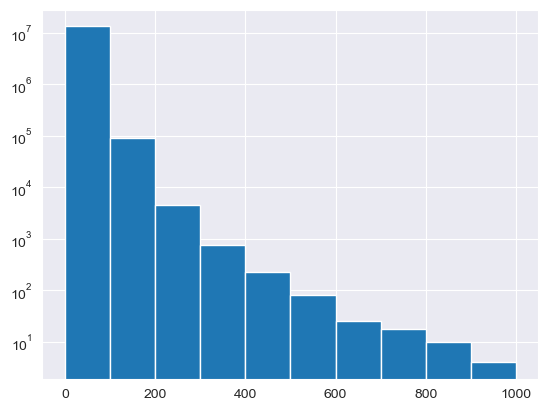

In [14]:
plt.hist(pT_MET, bins=10, range=(0, 1000))
plt.yscale('log')
plt.show()

In [6]:
a = np.random.random(4)
b = np.random.random(5)
M = np.random.random((4,5))

print(a)
print(b)
print(M)

[0.33655214 0.34397565 0.38593241 0.05882925]
[0.21449478 0.9704241  0.46276326 0.4228523  0.95357575]
[[0.09286935 0.45821835 0.34549498 0.20150941 0.77428953]
 [0.90328608 0.10380487 0.86743499 0.67171572 0.18148501]
 [0.7522354  0.89576653 0.59841033 0.00129682 0.90429036]
 [0.31404469 0.77391138 0.0339445  0.20470317 0.51945907]]


In [5]:
T = ot.emd(a, b, M)

AssertionError: 
Arrays are not almost equal to 6 decimals a and b vector must have the same sum
 ACTUAL: 3.321434778619411
 DESIRED: 1.9984402172656832